In [1]:
import gcsfs
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
import pyarrow
import seaborn as sns
import time

from google.cloud import bigquery
from google.cloud import storage
from pyarrow import parquet as pq
from sklearn.linear_model import LinearRegression

In [2]:
def sql2df(project, sql):
    bq = bigquery.Client(project=project)
    df = bq.query(sql).result().to_dataframe()
    return df

# QFF+BFC+VOU customers

In [5]:
redemption_df = sql2df("gcp-wow-rwds-ai-beh-seg-dev",
                    """
                    SELECT qff_redeemer_flag, bfc_redeemer_flag, vou_redeemer_flag, current_score, adapted_score
                    FROM `gcp-wow-rwds-ai-beh-seg-dev.engagement_weights.compared_scores`
                    where (qff_redeemer_flag > 0 and bfc_redeemer_flag > 0 and vou_redeemer_flag > 0)
                    """)
redemption_df["gap"] = redemption_df["adapted_score"]-redemption_df["current_score"]
redemption_df.describe()

/home/jovyan/my-conda-envs/alu/lib/python3.9/site-packages/google/auth/_default.py:68: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. We recommend you rerun `gcloud auth application-default login` and make sure a quota project is added. Or you can use service accounts instead. For more information about service accounts, see https://cloud.google.com/docs/authentication/
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


qff_redeemer_flag  bfc_redeemer_flag  vou_redeemer_flag  current_score  \
count         139.000000          139.00000       1.390000e+02     139.000000   
mean            4.668849            5.16843       4.472043e+00      54.309335   
std             0.000000            0.00000       8.913906e-16       7.894731   
min             4.668849            5.16843       4.472043e+00      34.289340   
25%             4.668849            5.16843       4.472043e+00      49.792789   
50%             4.668849            5.16843       4.472043e+00      54.368314   
75%             4.668849            5.16843       4.472043e+00      59.944706   
max             4.668849            5.16843       4.472043e+00      70.764213   

       adapted_score         gap  
count     139.000000  139.000000  
mean       61.367219    7.057883  
std         6.963205    1.114011  
min        43.319245    2.893349  
25%        57.309258    6.474956  
50%        61.430368    7.109929  
75%        66.532142    7.733854  
max        75.411262    9.457036

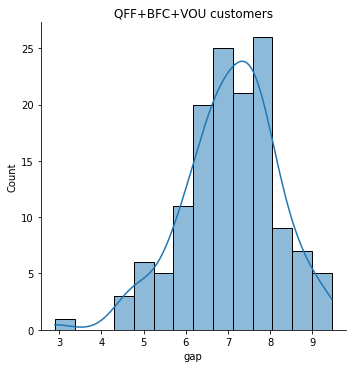

In [8]:
sns.displot(data=redemption_df, x="gap", kde=True).set(title="QFF+BFC+VOU customers")

# BFC+VOU customers

In [14]:
redemption_df = sql2df("gcp-wow-rwds-ai-beh-seg-dev",
                    """
                    SELECT qff_redeemer_flag, bfc_redeemer_flag, vou_redeemer_flag, current_score, adapted_score
                    FROM `gcp-wow-rwds-ai-beh-seg-dev.engagement_weights.compared_scores`
                    where (qff_redeemer_flag = 0 and bfc_redeemer_flag > 0 and vou_redeemer_flag > 0)
                    and MOD(ABS(FARM_FINGERPRINT(crn)), 2) = 1;
                    """)
redemption_df["gap"] = redemption_df["adapted_score"]-redemption_df["current_score"]
redemption_df.describe()

/home/jovyan/my-conda-envs/alu/lib/python3.9/site-packages/google/auth/_default.py:68: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. We recommend you rerun `gcloud auth application-default login` and make sure a quota project is added. Or you can use service accounts instead. For more information about service accounts, see https://cloud.google.com/docs/authentication/
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


qff_redeemer_flag  bfc_redeemer_flag  vou_redeemer_flag  current_score  \
count            14422.0        14422.00000       14422.000000   14422.000000   
mean                 0.0            5.16843           4.472043      50.009916   
std                  0.0            0.00000           0.000000       9.976568   
min                  0.0            5.16843           4.472043       6.792687   
25%                  0.0            5.16843           4.472043      43.702873   
50%                  0.0            5.16843           4.472043      50.409640   
75%                  0.0            5.16843           4.472043      56.797272   
max                  0.0            5.16843           4.472043      81.528993   

       adapted_score           gap  
count   14422.000000  14422.000000  
mean       53.020167      3.010251  
std         8.896699      1.206675  
min        15.529823     -2.128399  
25%        47.282608      2.238252  
50%        53.413110      3.008313  
75%        59.232469      3.765363  
max        80.790928      8.737137

In [18]:
sns.displot(data=redemption_df, x="gap", kde=True, bins=20).set(title="BFC+VOU customers")

# QFF+VOU Customers

In [21]:
redemption_df = sql2df("gcp-wow-rwds-ai-beh-seg-dev",
                    """
                    SELECT qff_redeemer_flag, bfc_redeemer_flag, vou_redeemer_flag, current_score, adapted_score
                    FROM `gcp-wow-rwds-ai-beh-seg-dev.engagement_weights.compared_scores`
                    where (qff_redeemer_flag > 0 and bfc_redeemer_flag = 0 and vou_redeemer_flag > 0);
                    """)
redemption_df["gap"] = redemption_df["adapted_score"]-redemption_df["current_score"]
redemption_df.describe()

/home/jovyan/my-conda-envs/alu/lib/python3.9/site-packages/google/auth/_default.py:68: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. We recommend you rerun `gcloud auth application-default login` and make sure a quota project is added. Or you can use service accounts instead. For more information about service accounts, see https://cloud.google.com/docs/authentication/
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


qff_redeemer_flag  bfc_redeemer_flag  vou_redeemer_flag  current_score  \
count        6698.000000             6698.0        6698.000000    6698.000000   
mean            4.668849                0.0           4.472043      43.339742   
std             0.000000                0.0           0.000000      11.791462   
min             4.668849                0.0           4.472043       6.466998   
25%             4.668849                0.0           4.472043      35.597850   
50%             4.668849                0.0           4.472043      43.800894   
75%             4.668849                0.0           4.472043      51.602284   
max             4.668849                0.0           4.472043      79.401277   

       adapted_score          gap  
count    6698.000000  6698.000000  
mean       46.622680     3.282939  
std        10.509710     1.397010  
min        13.838514    -2.536373  
25%        39.539263     2.380838  
50%        47.061884     3.249694  
75%        54.046435     4.105144  
max        78.096024     8.107822

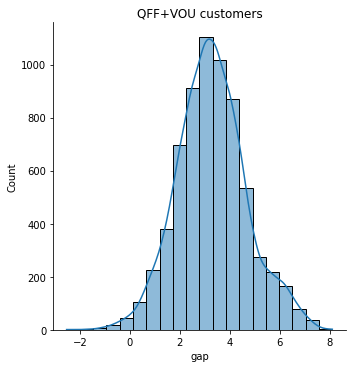

In [22]:
sns.displot(data=redemption_df, x="gap", kde=True, bins=20).set(title="QFF+VOU customers")

# QFF+BFC customers

In [23]:
redemption_df = sql2df("gcp-wow-rwds-ai-beh-seg-dev",
                    """
                    SELECT qff_redeemer_flag, bfc_redeemer_flag, vou_redeemer_flag, current_score, adapted_score
                    FROM `gcp-wow-rwds-ai-beh-seg-dev.engagement_weights.compared_scores`
                    where (qff_redeemer_flag > 0 and bfc_redeemer_flag > 0 and vou_redeemer_flag = 0);
                    """)
redemption_df["gap"] = redemption_df["adapted_score"]-redemption_df["current_score"]
redemption_df.describe()

/home/jovyan/my-conda-envs/alu/lib/python3.9/site-packages/google/auth/_default.py:68: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. We recommend you rerun `gcloud auth application-default login` and make sure a quota project is added. Or you can use service accounts instead. For more information about service accounts, see https://cloud.google.com/docs/authentication/
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


qff_redeemer_flag  bfc_redeemer_flag  vou_redeemer_flag  current_score  \
count         977.000000          977.00000              977.0     977.000000   
mean            4.668849            5.16843                0.0      49.795011   
std             0.000000            0.00000                0.0       9.865999   
min             4.668849            5.16843                0.0      17.768981   
25%             4.668849            5.16843                0.0      43.026654   
50%             4.668849            5.16843                0.0      50.075357   
75%             4.668849            5.16843                0.0      56.190091   
max             4.668849            5.16843                0.0      84.936271   

       adapted_score         gap  
count     977.000000  977.000000  
mean       53.045052    3.250042  
std         8.846227    1.160182  
min        25.132531   -2.376162  
25%        47.060876    2.545265  
50%        53.232146    3.267999  
75%        58.845271    3.955678  
max        82.560109    7.363550

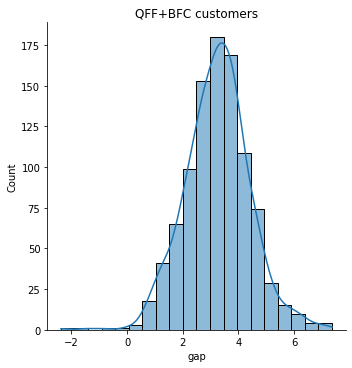

In [24]:
sns.displot(data=redemption_df, x="gap", kde=True, bins=20).set(title="QFF+BFC customers")

# QFF customers

In [25]:
redemption_df = sql2df("gcp-wow-rwds-ai-beh-seg-dev",
                    """
                    SELECT qff_redeemer_flag, bfc_redeemer_flag, vou_redeemer_flag, current_score, adapted_score
                    FROM `gcp-wow-rwds-ai-beh-seg-dev.engagement_weights.compared_scores`
                    where (qff_redeemer_flag > 0 and bfc_redeemer_flag = 0 and vou_redeemer_flag = 0)
                    and MOD(ABS(FARM_FINGERPRINT(crn)), 60) = 30;
                    """)
redemption_df["gap"] = redemption_df["adapted_score"]-redemption_df["current_score"]
redemption_df.describe()

/home/jovyan/my-conda-envs/alu/lib/python3.9/site-packages/google/auth/_default.py:68: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. We recommend you rerun `gcloud auth application-default login` and make sure a quota project is added. Or you can use service accounts instead. For more information about service accounts, see https://cloud.google.com/docs/authentication/
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


qff_redeemer_flag  bfc_redeemer_flag  vou_redeemer_flag  current_score  \
count       10573.000000            10573.0            10573.0   10573.000000   
mean            4.668849                0.0                0.0      32.326843   
std             0.000000                0.0                0.0      13.176677   
min             4.668849                0.0                0.0       0.000000   
25%             4.668849                0.0                0.0      21.755313   
50%             4.668849                0.0                0.0      30.818208   
75%             4.668849                0.0                0.0      41.649384   
max             4.668849                0.0                0.0      78.803912   

       adapted_score           gap  
count   10573.000000  10573.000000  
mean       32.500301      0.173458  
std        11.628213      1.639604  
min         4.668849     -6.146688  
25%        23.159021     -1.031757  
50%        31.160626      0.172453  
75%        40.536631      1.568769  
max        73.440098      4.668849

In [26]:
sns.displot(data=redemption_df, x="gap", kde=True, bins=20).set(title="QFF customers")

# BFC customers

In [27]:
redemption_df = sql2df("gcp-wow-rwds-ai-beh-seg-dev",
                    """
                    SELECT qff_redeemer_flag, bfc_redeemer_flag, vou_redeemer_flag, current_score, adapted_score
                    FROM `gcp-wow-rwds-ai-beh-seg-dev.engagement_weights.compared_scores`
                    where (qff_redeemer_flag = 0 and bfc_redeemer_flag > 0 and vou_redeemer_flag = 0)
                    and MOD(ABS(FARM_FINGERPRINT(crn)), 20) = 10;
                    """)
redemption_df["gap"] = redemption_df["adapted_score"]-redemption_df["current_score"]
redemption_df.describe()

/home/jovyan/my-conda-envs/alu/lib/python3.9/site-packages/google/auth/_default.py:68: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. We recommend you rerun `gcloud auth application-default login` and make sure a quota project is added. Or you can use service accounts instead. For more information about service accounts, see https://cloud.google.com/docs/authentication/
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


qff_redeemer_flag  bfc_redeemer_flag  vou_redeemer_flag  current_score  \
count            11440.0        11440.00000            11440.0   11440.000000   
mean                 0.0            5.16843                0.0      44.700942   
std                  0.0            0.00000                0.0      12.317305   
min                  0.0            5.16843                0.0       0.000000   
25%                  0.0            5.16843                0.0      36.897044   
50%                  0.0            5.16843                0.0      45.565605   
75%                  0.0            5.16843                0.0      53.753192   
max                  0.0            5.16843                0.0      80.738323   

       adapted_score           gap  
count   11440.000000  11440.000000  
mean       43.903456     -0.797486  
std        10.948389      1.469336  
min         5.168430     -6.394270  
25%        36.926258     -1.838769  
50%        44.889553     -0.917636  
75%        52.000492      0.043473  
max        76.180950      5.168430

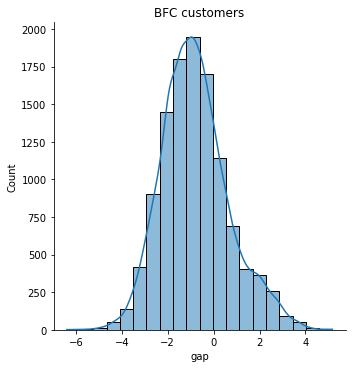

In [29]:
sns.displot(data=redemption_df, x="gap", kde=True, bins=20).set(title="BFC customers")

# VOU customers

In [30]:
redemption_df = sql2df("gcp-wow-rwds-ai-beh-seg-dev",
                    """
                    SELECT qff_redeemer_flag, bfc_redeemer_flag, vou_redeemer_flag, current_score, adapted_score
                    FROM `gcp-wow-rwds-ai-beh-seg-dev.engagement_weights.compared_scores`
                    where (qff_redeemer_flag = 0 and bfc_redeemer_flag = 0 and vou_redeemer_flag > 0)
                    and MOD(ABS(FARM_FINGERPRINT(crn)), 300) = 150;
                    """)
redemption_df["gap"] = redemption_df["adapted_score"]-redemption_df["current_score"]
redemption_df.describe()

/home/jovyan/my-conda-envs/alu/lib/python3.9/site-packages/google/auth/_default.py:68: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. We recommend you rerun `gcloud auth application-default login` and make sure a quota project is added. Or you can use service accounts instead. For more information about service accounts, see https://cloud.google.com/docs/authentication/
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


qff_redeemer_flag  bfc_redeemer_flag  vou_redeemer_flag  current_score  \
count            10800.0            10800.0       10800.000000   10800.000000   
mean                 0.0                0.0           4.472043      28.215990   
std                  0.0                0.0           0.000000      12.675102   
min                  0.0                0.0           4.472043       0.000000   
25%                  0.0                0.0           4.472043      17.815841   
50%                  0.0                0.0           4.472043      25.517405   
75%                  0.0                0.0           4.472043      36.620592   
max                  0.0                0.0           4.472043      74.772395   

       adapted_score           gap  
count   10800.000000  10800.000000  
mean       28.761389      0.545399  
std        11.156012      1.602030  
min         4.472043     -5.640726  
25%        19.743383     -0.653267  
50%        26.368338      0.825013  
75%        36.082479      1.890628  
max        70.264915      4.472043

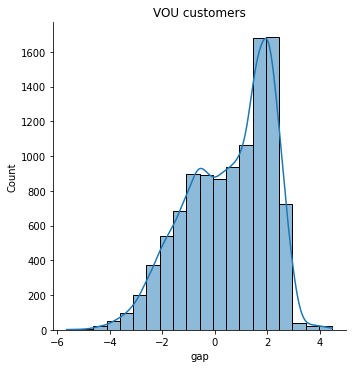

In [31]:
sns.displot(data=redemption_df, x="gap", kde=True, bins=20).set(title="VOU customers")

# Total redeemers

In [36]:
redemption_df = sql2df("gcp-wow-rwds-ai-beh-seg-dev",
                    """
                    SELECT qff_redeemer_flag, bfc_redeemer_flag, vou_redeemer_flag, current_score, adapted_score
                    FROM `gcp-wow-rwds-ai-beh-seg-dev.engagement_weights.compared_scores`
                    where (qff_redeemer_flag > 0 or bfc_redeemer_flag > 0 or vou_redeemer_flag > 0)
                    and MOD(ABS(FARM_FINGERPRINT(crn)), 400) = 200;
                    """)
redemption_df["gap"] = redemption_df["adapted_score"]-redemption_df["current_score"]
redemption_df.describe()

/home/jovyan/my-conda-envs/alu/lib/python3.9/site-packages/google/auth/_default.py:68: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. We recommend you rerun `gcloud auth application-default login` and make sure a quota project is added. Or you can use service accounts instead. For more information about service accounts, see https://cloud.google.com/docs/authentication/
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


qff_redeemer_flag  bfc_redeemer_flag  vou_redeemer_flag  current_score  \
count       10470.000000       10470.000000       10470.000000   10470.000000   
mean            0.721063           0.293223           3.563967      29.860966   
std             1.687268           1.195684           1.799073      13.426754   
min             0.000000           0.000000           0.000000       0.000000   
25%             0.000000           0.000000           4.472043      19.002605   
50%             0.000000           0.000000           4.472043      27.191443   
75%             0.000000           0.000000           4.472043      39.473806   
max             4.668849           5.168430           4.472043      73.653595   

       adapted_score           gap  
count   10470.000000  10470.000000  
mean       30.293158      0.432192  
std        11.933058      1.652296  
min         4.472043     -5.565859  
25%        20.472501     -0.838181  
50%        27.995160      0.656544  
75%        38.833143      1.833809  
max        68.594328      8.393739

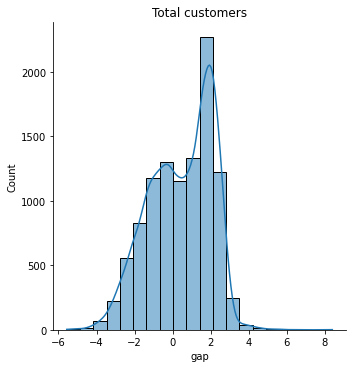

In [38]:
sns.displot(data=redemption_df, x="gap", kde=True, bins=20).set(title="Total customers")